# 01 Introduction

In [1]:
import jax.random
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

az.style.use("arviz-darkgrid")
rng_key = random.PRNGKey(0)
numpyro.set_platform("cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


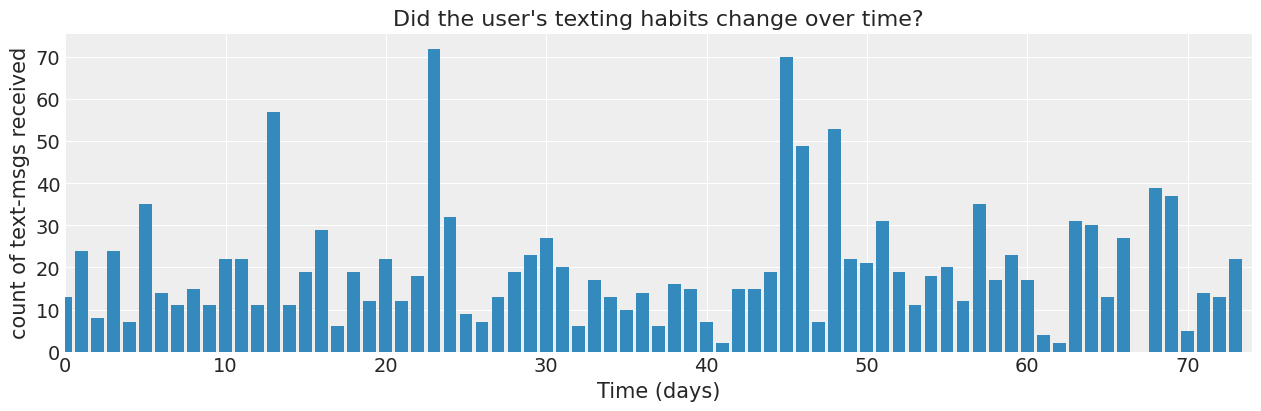

In [53]:
PATH = 'txtdata.csv'

plt.figure(figsize=(12.5, 4))

count_data = np.loadtxt(PATH)
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [54]:
def model(data):
  n_data = len(data)

  alpha = 1.0 / data.mean() # 受信数の平均の逆数（なぜこのように設定するかについては参考書を参照）
  lambda_1 = numpyro.sample("lambda_1", dist.Exponential(rate=alpha))
  lambda_2 = numpyro.sample("lambda_2", dist.Exponential(rate=alpha))

  tau = numpyro.sample("tau", dist.Uniform(low=0, high=n_data))

  idx = jnp.arange(n_data) # Index
  with numpyro.plate("data_plate", n_data):
    lambda_ = numpyro.deterministic("lambda_", jnp.where(tau > idx, lambda_1, lambda_2))
  numpyro.sample("obs", dist.Poisson(rate=lambda_), obs=data)

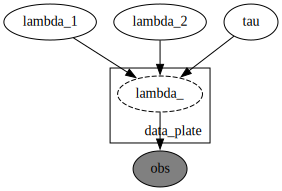

In [55]:
numpyro.render_model(model, model_args=(count_data,))

In [56]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
sample_kwargs = dict(
    sampler=kernel, num_warmup=1000, num_samples=1000, num_chains=1, chain_method="parallel"
)
mcmc = MCMC(**sample_kwargs)
mcmc.run(rng_key_, data=count_data)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 434.22it/s, 1023 steps of size 1.40e-03. acc. prob=0.85]


In [57]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  lambda_1     17.72      0.62     17.69     16.76     18.74     63.15      1.00
  lambda_2     22.66      0.91     22.59     21.12     24.13    141.47      1.01
       tau     43.65      0.91     43.79     42.30     44.99     47.49      1.00

Number of divergences: 0


In [58]:
mcmc.get_samples()

{'lambda_': Array([[17.509542, 17.509542, 17.509542, ..., 22.237938, 22.237938,
         22.237938],
        [17.30659 , 17.30659 , 17.30659 , ..., 22.601326, 22.601326,
         22.601326],
        [17.9296  , 17.9296  , 17.9296  , ..., 22.095776, 22.095776,
         22.095776],
        ...,
        [18.318348, 18.318348, 18.318348, ..., 24.515247, 24.515247,
         24.515247],
        [17.842316, 17.842316, 17.842316, ..., 23.71436 , 23.71436 ,
         23.71436 ],
        [17.863241, 17.863241, 17.863241, ..., 23.216055, 23.216055,
         23.216055]], dtype=float32),
 'lambda_1': Array([17.509542, 17.30659 , 17.9296  , 17.862751, 17.978325, 18.072893,
        18.082798, 18.587112, 19.07164 , 18.42826 , 18.007479, 17.834309,
        17.84293 , 17.657528, 17.859493, 17.936222, 17.693045, 17.777973,
        17.392822, 17.082123, 17.198442, 17.131544, 17.26888 , 17.386251,
        17.81536 , 17.834839, 17.921543, 17.28853 , 17.398525, 17.065495,
        17.15109 , 17.561676, 17.5763

In [59]:
mcmc.get_samples()["lambda_1"][:5]

Array([17.509542, 17.30659 , 17.9296  , 17.862751, 17.978325], dtype=float32)

In [60]:
idata = az.from_numpyro(mcmc)

In [61]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

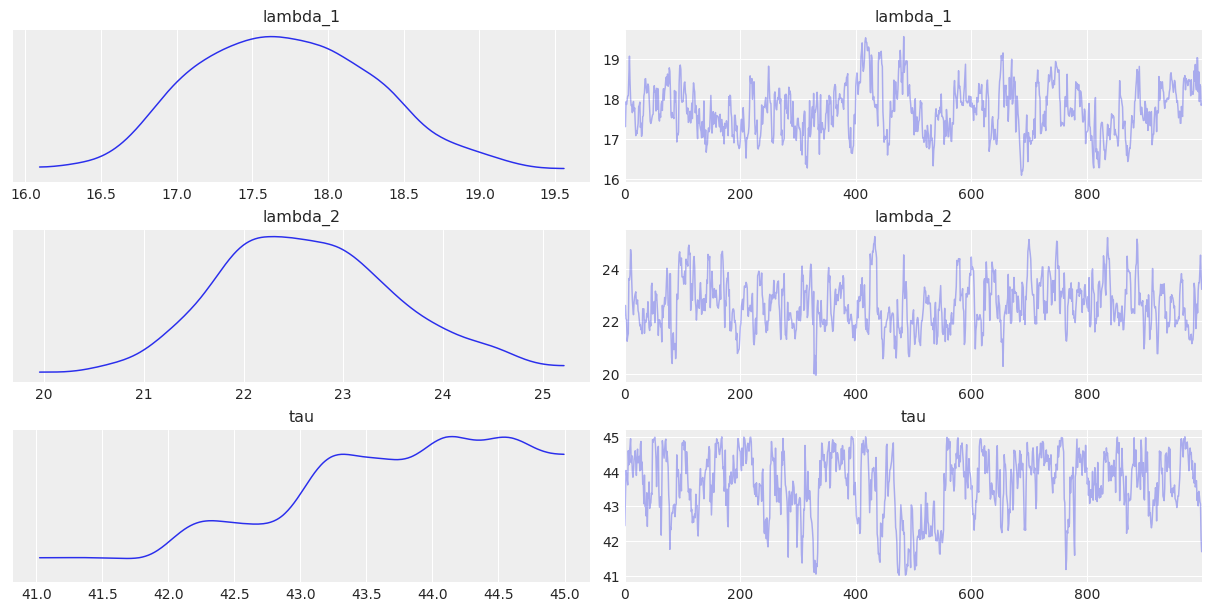

In [62]:
var_names = ["lambda_1", "lambda_2", "tau"]
az.plot_trace(idata, var_names=var_names);

#### try original doc's code.

In [63]:
lambda_1_samples = mcmc.get_samples()["lambda_1"][:]
lambda_2_samples = mcmc.get_samples()["lambda_2"][:]
tau_samples = mcmc.get_samples()["tau"][:]

Text(0, 0.5, 'probability')

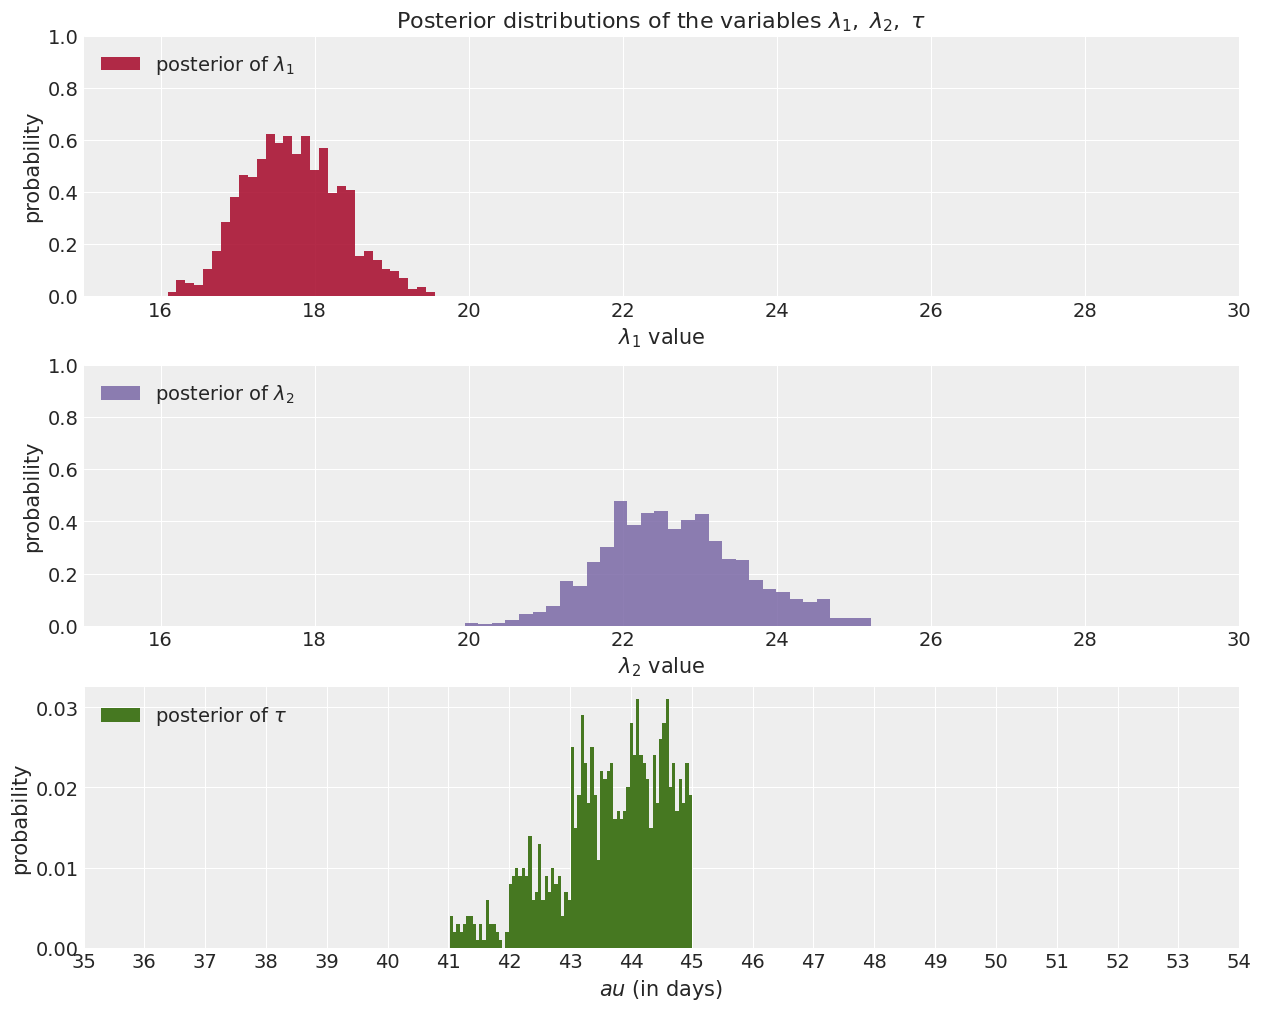

In [65]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("probability")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("probability")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1, label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.xlim([35, len(count_data) - 20])
plt.xlabel("$\tau$ (in days)")
plt.ylabel("probability")


#### code ported by chatgpt
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

In [18]:
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

# Data
#count_data = jnp.array( ...) # replace with your actual count_data
n_count_data = len(count_data)

# Model
def model(n_count_data, count_data):
    alpha = 1.0/jnp.mean(count_data)
    lambda_1 = numpyro.sample("lambda_1", numpyro.distributions.Exponential(alpha))
    lambda_2 = numpyro.sample("lambda_2", numpyro.distributions.Exponential(alpha))
    tau = numpyro.sample("tau", numpyro.distributions.Uniform(0, n_count_data))
    idx = jnp.arange(n_count_data)
    lambda_ = jnp.where(tau > idx, lambda_1, lambda_2)
    numpyro.sample("obs", numpyro.distributions.Poisson(lambda_), obs=count_data)

# Inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key_, n_count_data=n_count_data, count_data=count_data)

# Extract samples
posterior_samples = mcmc.get_samples()
lambda_1_samples = posterior_samples['lambda_1']
lambda_2_samples = posterior_samples['lambda_2']
tau_samples = posterior_samples['tau']

# Plotting
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * jnp.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(jnp.arange(n_count_data))

plt.legend(loc="upper left")
plt.xlim([35, n_count_data - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")
plt.show()

NameError: name 'count_data' is not defined

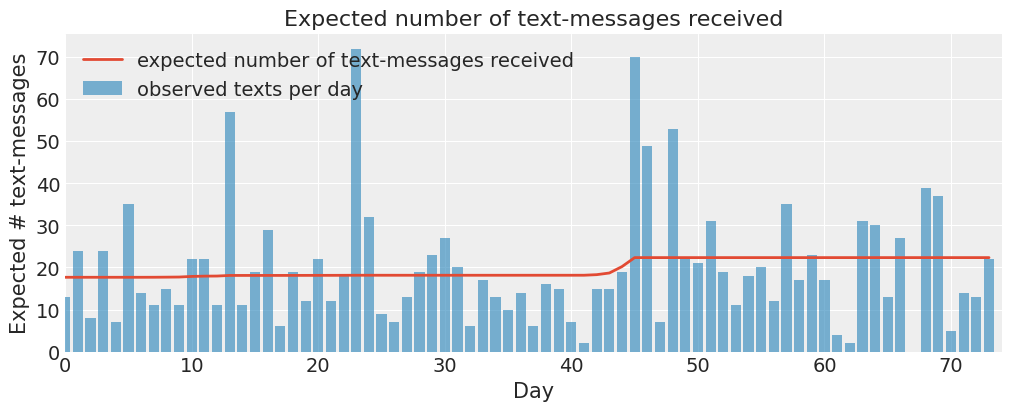

In [67]:
plt.figure(figsize=(10, 4))

# tau_samples, lambda_1_samples, lambda_2_samples は
# それぞれ対応する事後分布からのN個のサンプルを含んでいる。
N = tau_samples.shape[0]

expected_texts_per_day = np.zeros(n_count_data)
for day in range(n_count_data):
  # ix is a bool index of all tau samples corresponding to
  # the switchpoint occurring prior to value of 'day'
  ix = day < tau_samples
  # Each posterior sample corresponds to a value for tau.
  # for each day, that value of tau indicates whether we're "before"
  # (in the lambda1 "regime") or
  #  "after" (in the lambda2 "regime") the switchpoint.
  # by taking the posterior sample of lambda1/2 accordingly, we can average
  # over all samples to get an expected value for lambda on that day.
  # As explained, the "message count" random variable is Poisson distributed,
  # and therefore lambda (the poisson parameter) is the expected value of
  # "message count".
  expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=2, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

# 02 NumPyro入門 (1)

In [68]:
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [69]:
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on NumPyro v0.12.1
Running on ArviZ v0.15.1


In [70]:
def model(data=None):
    lambda_ = numpyro.sample('lambda_', dist.Exponential(1), obs=data)

In [73]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_)

sample: 100%|██████████| 2000/2000 [00:02<00:00, 689.85it/s, 1 steps of size 8.28e-01. acc. prob=0.88] 


array([[<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>]], dtype=object)

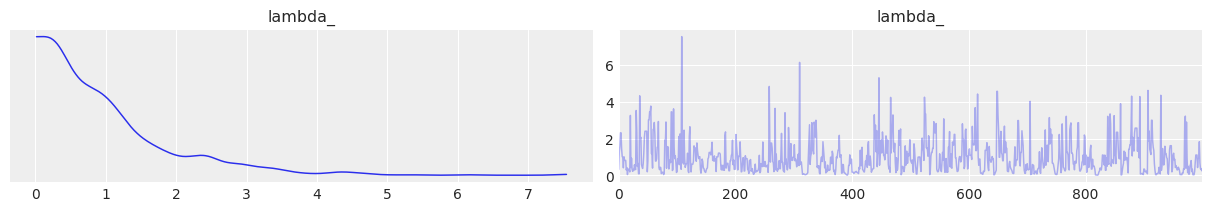

In [74]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

In [75]:
def model(data=None):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    obs = numpyro.sample('obs', dist.Normal(mu, 1), obs=data)

In [76]:
rng_key, rng_key_ = random.split(rng_key)
observed = jax.random.normal(rng_key_, (100,))

In [77]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_9724\2021168712.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [00:00<00:00, 4760.71it/s, 3 steps of size 8.94e-01. acc. prob=0.94]


In [78]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.10      0.10     -0.11     -0.25      0.07    917.61      1.00

Number of divergences: 0


In [79]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_9724\360416303.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=4000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 5000/5000 [00:01<00:00, 4789.30it/s, 7 steps of size 8.75e-01. acc. prob=0.94]


In [80]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.10      0.10     -0.10     -0.28      0.05    725.98      1.00

Number of divergences: 0


#### 第9回_2)ベイスの定理を用いた研究事例の紹介.ipynb からの引用

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import scipy
import pickle
from sklearn.preprocessing import StandardScaler

In [3]:
df_Process = pd.read_csv('Process.csv')

#プロセスのデータの欠損値処理
i=23 #この数字は、欠損値のSampleNo-1になる (0から始まっているため)
df_Process_drop=df_Process.drop([i], axis=0)
df_Process_drop=df_Process_drop.drop(np.arange(88,123), axis=0)
df_Process_drop

,Sample No,Nucleator,Cryst. Temp.,Cryst. Time,Ratio of PLLA
0,1,0,90,5.0,100
1,2,0,90,5.0,90
2,3,0,90,5.0,70
3,4,0,90,5.0,50
4,5,0,90,20.0,100
...,...,...,...,...,...
83,84,0,0,0.0,50
84,85,1,0,0.0,100
85,86,1,0,0.0,90
86,87,1,0,0.0,70


In [4]:
# プロセスのデータを標準化
ss_Process = StandardScaler()
Process_ss = ss_Process.fit_transform(df_Process_drop)
df_Process_ss=pd.DataFrame(Process_ss)
df_Process_ss.columns=df_Process_drop.columns
df_Process_ss.head()

,Sample No,Nucleator,Cryst. Temp.,Cryst. Time,Ratio of PLLA
0,-1.718389,-1.011561,-0.707591,-0.783544,1.162440
1,-1.679098,-1.011561,-0.707591,-0.783544,0.638438
2,-1.639808,-1.011561,-0.707591,-0.783544,-0.409564
3,-1.600518,-1.011561,-0.707591,-0.783544,-1.457567
4,-1.561227,-1.011561,-0.707591,1.092649,1.162440


In [5]:
df_Property = pd.read_csv('Property.csv')

#物性のデータの欠損値処理
df_Property_drop=df_Property.drop([i], axis=0)
df_Property_drop

,Sample No,Yield stress/MPa,Degradation weight/mg
0,1,10.321033,0.571667
1,2,15.796833,0.536667
2,3,9.553433,0.540000
3,4,8.881233,0.501667
4,5,33.904267,0.281667
...,...,...,...
83,84,4.708000,0.171667
84,85,6.283533,0.758333
85,86,6.491800,0.631667
86,87,7.354367,0.598333


In [6]:
# 物性のデータを標準化
ss_Property = StandardScaler()
Property_ss = ss_Property.fit_transform(df_Property_drop)
df_Property_ss=pd.DataFrame(Property_ss)
df_Property_ss.columns=df_Property_drop.columns
df_Property_ss.head()

,Sample No,Yield stress/MPa,Degradation weight/mg
0,-1.718389,-0.926261,0.813314
1,-1.679098,-0.427185,0.674417
2,-1.639808,-0.996222,0.687645
3,-1.600518,-1.057487,0.535519
4,-1.561227,1.223165,-0.337550


In [7]:
#今回からは、X線の各ファイルをまとめたデータを配布
#既に、面積で割る操作を行なっているが、面積の算出方法が異なる
#以前配布したscPLA-○○.csvというファイルは、「サンプル有のデータ-サンプル無のデータ」という処理を行ったもの
#WAXD.csvは、以前と異なり処理前の面積で割っている。つまり、(サンプル有のデータ-サンプル無のデータ)/サンプル有のデータの面積
#WAXD-old.csvは、以前のように処理後の面積で割っている。つまり、 (サンプル有のデータ-サンプル無のデータ)/((サンプル有のデータ-サンプル無のデータ)の面積)
df_WAXD=pd.read_csv('WAXD.csv', header=0, index_col=0)

In [8]:
#今回からは、まとめたデータを配布
#面積で割る処理は、WAXDと同様
df_SAXS=pd.read_csv('SAXS.csv', header=0, index_col=0)

In [9]:
df_WAXD=df_WAXD.drop(24)
df_SAXS=df_SAXS.drop(24)

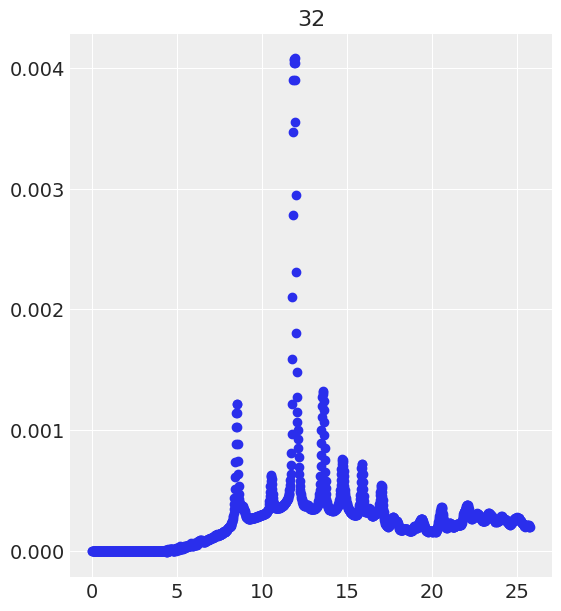

In [10]:
# sample No 32を用いる
i=32
X=np.array(df_WAXD.columns.astype(float))
y=np.array(df_WAXD.loc[i])

plt.figure(1, figsize=(5.5,6))
plt.scatter(X, y)
plt.title(i)
plt.show()

In [11]:
# ガウス関数の定義
# xは入力値。今回はqの値。
# muとsigmaは平均と標準偏差
# weightは、高さを決める
def gauss(x, mu, sigma, weight):
    return weight*np.power(2*math.pi*np.power(sigma, 2), -0.5)*np.exp(-np.power((x-mu),2)/(2*np.power(sigma,2)))

C:\Users\yoshi\AppData\Local\Temp\ipykernel_17912\2727745248.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


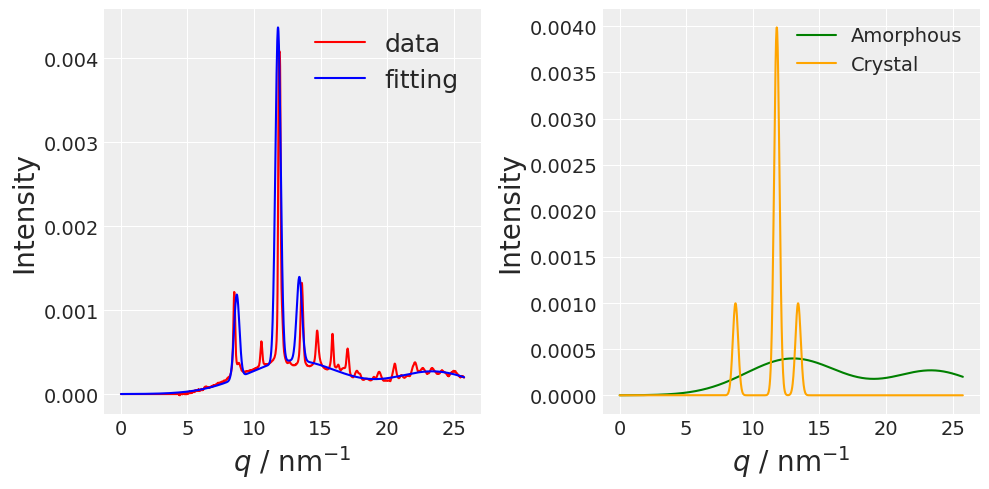

In [12]:
# ここでは主要なピークのみフィッティング
# 通常(機械学習など用いない場合)は、ガウス分布のパラメータを調整して手作業でピークフィッティングしている
gauss1=gauss(X, 13, 3.5, 0.0035) # ブロードなピーク1
gauss2=gauss(X, 23.5, 3, 0.002) # ブロードなピーク2
gauss3=gauss(X, 8.7, 0.2, 0.0005) # シャープなピーク1
gauss4=gauss(X, 11.8, 0.2, 0.002) # シャープなピーク2
gauss5=gauss(X, 13.4, 0.2, 0.0005) # シャープなピーク3

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(X, y, "red", label="data")
plt.plot(X, gauss1+gauss2+gauss3+gauss4+gauss5, "blue", label="fitting")
plt.xlabel('$q$ / nm$^{-1}$', size=20)
plt.ylabel('Intensity', size=20)
plt.legend(fontsize=18)
plt.subplot(122)
plt.plot(X, gauss1+gauss2, "green", label='Amorphous')
plt.plot(X, gauss3+gauss4+gauss5, "orange", label='Crystal')
plt.xlabel('$q$ / nm$^{-1}$', size=20)
plt.ylabel('Intensity', size=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
# どうしても人間による主観が入る、多量のサンプルの処理が難しいなどの問題があった

In [17]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_value

def gauss(x, mu, sigma, weight):
    return weight * jnp.exp(-0.5 * ((x - mu) / sigma)**2)

def model(X, y):
    # Priors
    mu1 = numpyro.sample('mu1', dist.Normal(13, 1))
    mu2 = numpyro.sample('mu2', dist.Normal(23.5, 1))
    mu3 = numpyro.sample('mu3', dist.Normal(8.7, 0.01))
    mu4 = numpyro.sample('mu4', dist.Normal(11.8, 0.01))
    mu5 = numpyro.sample('mu5', dist.Normal(13.3, 0.01))

    sigma1 = numpyro.sample('sigma1', dist.Normal(4, 0.2))
    sigma2 = numpyro.sample('sigma2', dist.Normal(4, 0.2))
    sigma3 = numpyro.sample('sigma3', dist.Normal(0.2, 0.05))
    sigma4 = numpyro.sample('sigma4', dist.Normal(0.2, 0.05))
    sigma5 = numpyro.sample('sigma5', dist.Normal(0.2, 0.05))

    weight1 = numpyro.sample('weight1', dist.HalfCauchy(1))
    weight2 = numpyro.sample('weight2', dist.HalfCauchy(1))
    weight3 = numpyro.sample('weight3', dist.HalfCauchy(1))
    weight4 = numpyro.sample('weight4', dist.HalfCauchy(1))
    weight5 = numpyro.sample('weight5', dist.HalfCauchy(1))

    epsilon = numpyro.sample('epsilon', dist.HalfCauchy(1))

    # Gaussian functions
    Gauss1 = gauss(X, mu1, sigma1, weight1)
    Gauss2 = gauss(X, mu2, sigma2, weight2)
    Gauss3 = gauss(X, mu3, sigma3, weight3)
    Gauss4 = gauss(X, mu4, sigma4, weight4)
    Gauss5 = gauss(X, mu5, sigma5, weight5)

    # Likelihood
    mu = Gauss1 + Gauss2 + Gauss3 + Gauss4 + Gauss5
    numpyro.sample('y_pred', dist.Normal(mu, epsilon), obs=y)

# Assuming X and y are your data
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=30000, num_samples=10000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, X, y)
mcmc.print_summary()

C:\Users\yoshi\AppData\Local\Temp\ipykernel_17912\1333904544.py:46: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=30000, num_samples=10000, num_chains=2)
warmup:  54%|█████▍    | 21642/40000 [01:42<04:01, 76.02it/s, 511 steps of size 2.46e-02. acc. prob=0.80] 

In [71]:
idata = az.from_numpyro(mcmc)

In [72]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

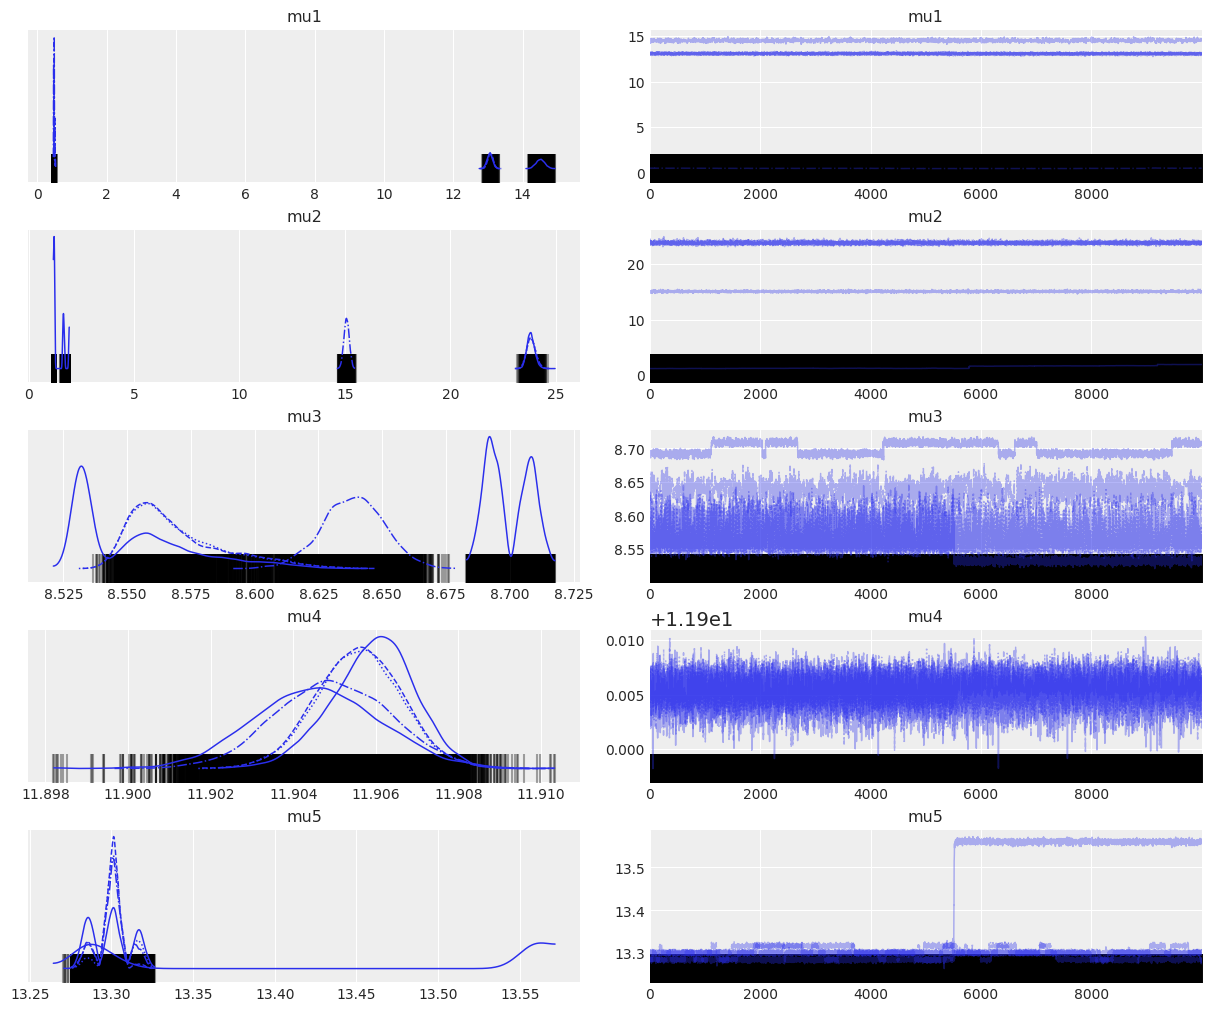

In [78]:
var_names = ["mu1", "mu2", "mu3", "mu4", "mu5"]
az.plot_trace(idata, var_names=var_names);

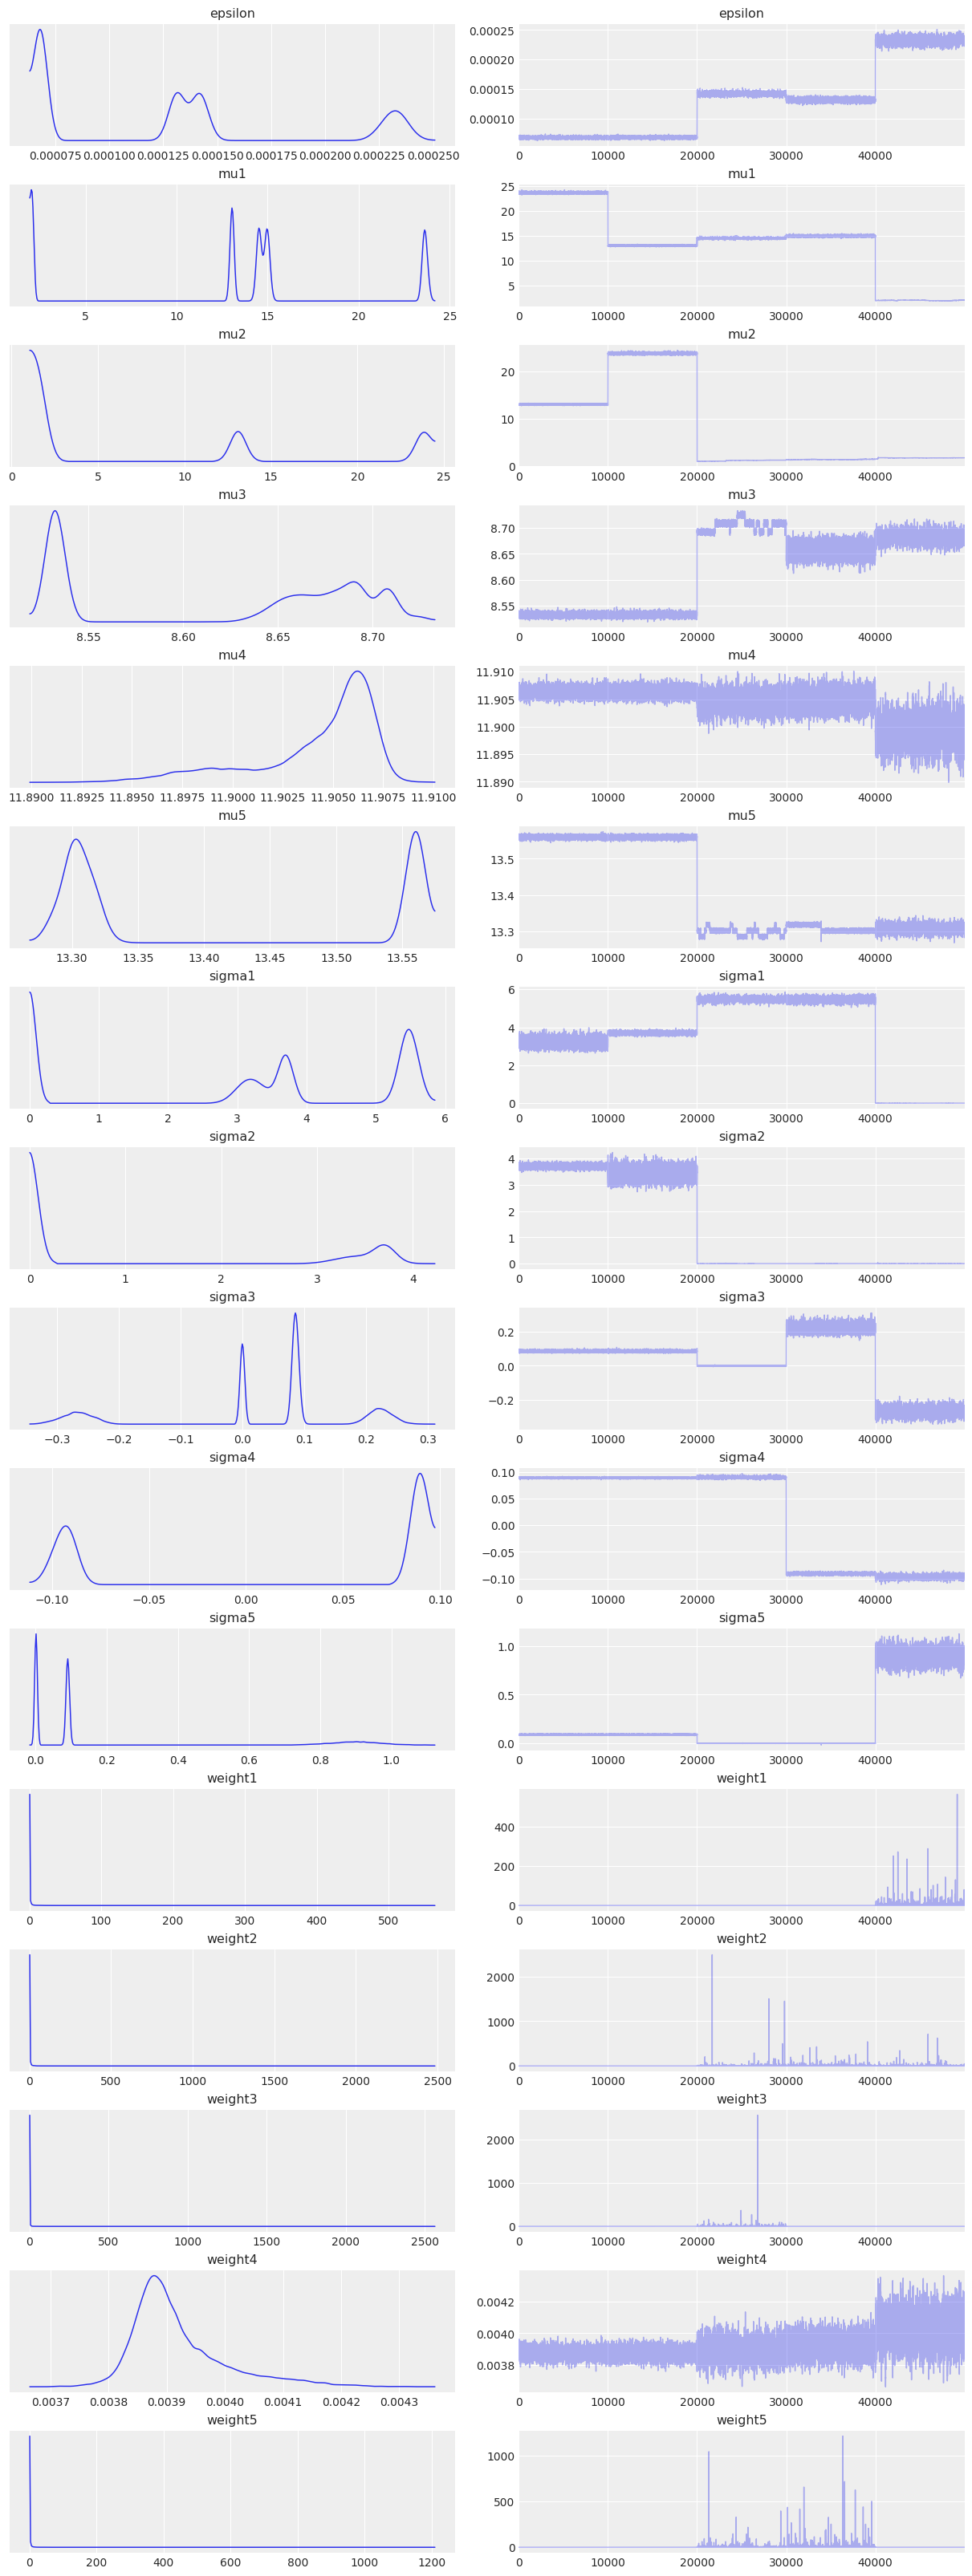

In [79]:
posterior_samples = mcmc.get_samples()
az.plot_trace(posterior_samples)
plt.show()

In [67]:
# Assuming that mcmc is your MCMC object from numpyro.infer.MCMC
samples = mcmc.get_samples()

# Calculate the mean of posterior samples
mu1_mean = jnp.mean(samples['mu1'])
sigma1_mean = jnp.mean(samples['sigma1'])
weight1_mean = jnp.mean(samples['weight1'])

mu2_mean = jnp.mean(samples['mu2'])
sigma2_mean = jnp.mean(samples['sigma2'])
weight2_mean = jnp.mean(samples['weight2'])

mu3_mean = jnp.mean(samples['mu3'])
sigma3_mean = jnp.mean(samples['sigma3'])
weight3_mean = jnp.mean(samples['weight3'])

mu4_mean = jnp.mean(samples['mu4'])
sigma4_mean = jnp.mean(samples['sigma4'])
weight4_mean = jnp.mean(samples['weight4'])

mu5_mean = jnp.mean(samples['mu5'])
sigma5_mean = jnp.mean(samples['sigma5'])
weight5_mean = jnp.mean(samples['weight5'])

# Print parameters
print('mu1: ', round(mu1_mean.item(),2), 'sigma1: ', round(sigma1_mean.item(),3), 'weight1: ', round(weight1_mean.item(),6))
print('mu2: ', round(mu2_mean.item(),2), 'sigma2: ', round(sigma2_mean.item(),3), 'weight2: ', round(weight2_mean.item(),6))
print('mu3: ', round(mu3_mean.item(),2), 'sigma3: ', round(sigma3_mean.item(),3), 'weight3: ', round(weight3_mean.item(),6))
print('mu4: ', round(mu4_mean.item(),2), 'sigma4: ', round(sigma4_mean.item(),3), 'weight4: ', round(weight4_mean.item(),6))
print('mu5: ', round(mu5_mean.item(),2), 'sigma5: ', round(sigma5_mean.item(),3), 'weight5: ', round(weight5_mean.item(),6))


mu1:  13.02 sigma1:  3.696 weight1:  0.000443
mu2:  23.81 sigma2:  3.424 weight2:  0.000263
mu3:  8.53 sigma3:  0.086 weight3:  0.000912
mu4:  11.91 sigma4:  0.0 weight4:  0.003876
mu5:  13.56 sigma5:  0.089 weight5:  0.000852


In [68]:
gauss1 = gauss(X, mu1_mean, sigma1_mean, weight1_mean)
gauss2 = gauss(X, mu2_mean, sigma2_mean, weight2_mean)
gauss3 = gauss(X, mu3_mean, sigma3_mean, weight3_mean)
gauss4 = gauss(X, mu4_mean, sigma4_mean, weight4_mean)
gauss5 = gauss(X, mu5_mean, sigma5_mean, weight5_mean)

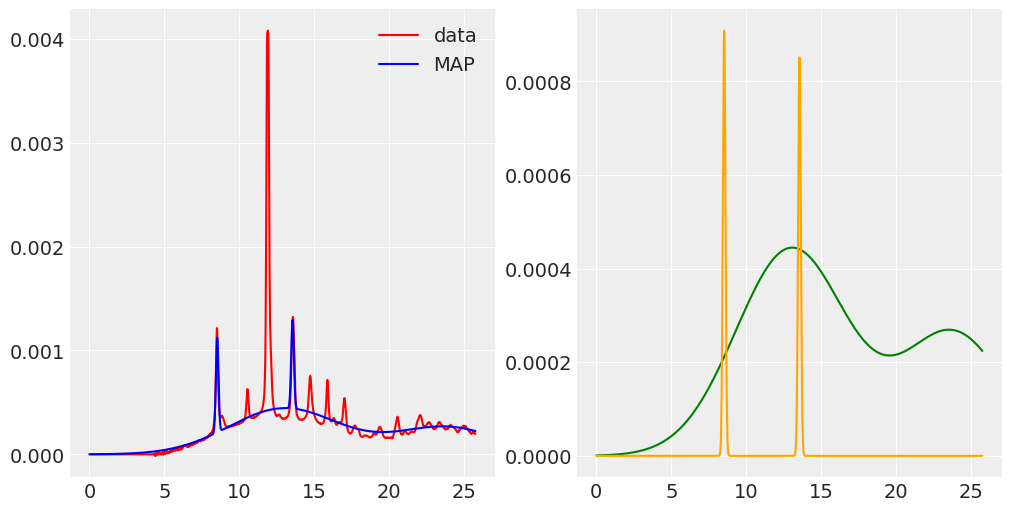

In [69]:
# サンプリングの平均を予測値として、ピークフィットする
# この場合、得られる結果は一つ
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(X, y, "red", label="data")
plt.plot(X, gauss1+gauss2+gauss3+gauss4+gauss5, "blue", label="MAP")
plt.legend()
plt.subplot(122)
plt.plot(X, gauss1+gauss2, "green")
plt.plot(X, gauss3+gauss4+gauss5, "orange")
plt.show()

# 03 NumPyro入門 (2)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

plt.style.use("bmh")
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [20]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


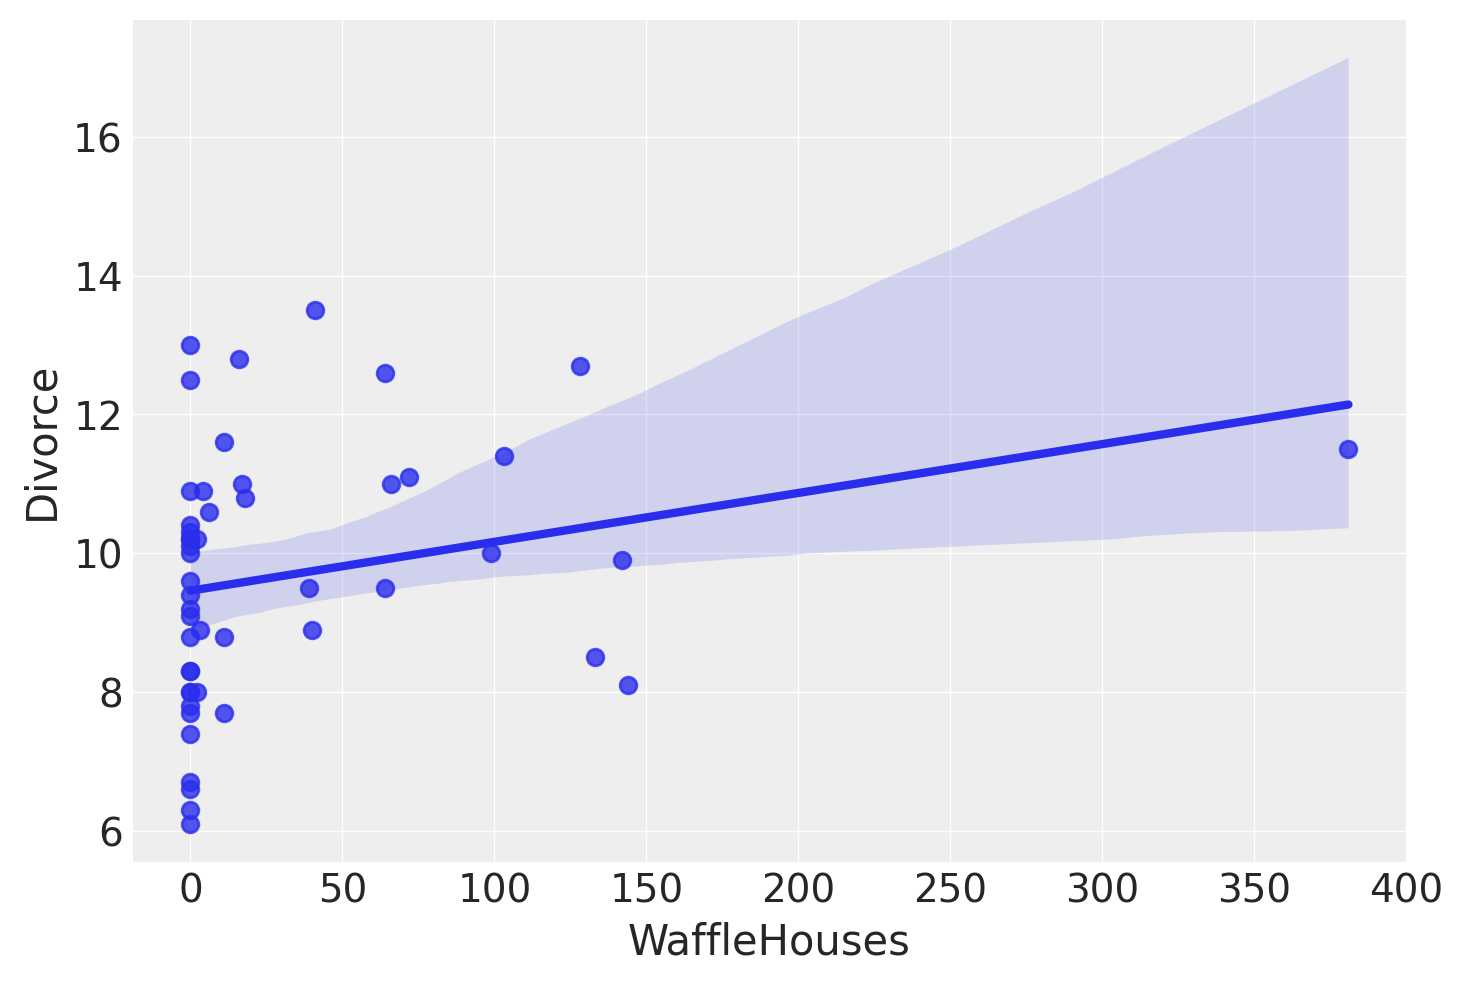

In [21]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);

In [22]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

In [23]:
def model(marriage=None, age=None, divorce=None):
  a = numpyro.sample("a", dist.Normal(0.0, 0.2))
  M, A = 0.0, 0.0
  if marriage is not None:
    bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
    M = bM * marriage
  if age is not None:
    bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
    A = bA * age
  sigma = numpyro.sample("sigma", dist.Exponential(1.0))
  mu = a + M + A
  numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

In [24]:
rng_key, rng_key_ = random.split(rng_key)

In [25]:
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=2)
mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_17912\2487653904.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=2)
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3165.97it/s, 3 steps of size 8.83e-01. acc. prob=0.89] 


In [26]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.11     -0.00     -0.18      0.19   4160.29      1.00
        bM      0.34      0.13      0.34      0.14      0.57   4424.31      1.00
     sigma      0.95      0.10      0.94      0.78      1.10   3933.23      1.00

Number of divergences: 0


In [27]:
samples_1 = mcmc.get_samples()
samples_1

{'a': Array([-0.10718831, -0.05141535, -0.00214576, ..., -0.17315005,
        -0.17566529,  0.02722712], dtype=float32),
 'bM': Array([0.3774677 , 0.5871023 , 0.10871746, ..., 0.25100204, 0.17177323,
        0.29853046], dtype=float32),
 'sigma': Array([0.86219203, 0.85640216, 1.0335474 , ..., 0.8583429 , 0.91076267,
        0.9642306 ], dtype=float32)}

In [28]:
type(np.array(samples_1['a']))

numpy.ndarray

In [29]:
idata_1 = az.from_numpyro(mcmc)
idata_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [30]:
idata_1.posterior["a"].sel(chain=0)

<xarray.DataArray 'a' (draw: 2000)>
array([-0.10718831, -0.05141535, -0.00214576, ..., -0.17767388,
       -0.12640883, -0.15183619], dtype=float32)
Coordinates:
    chain    int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [31]:
idata_1.posterior["a"].sel(chain=0)[:10]

<xarray.DataArray 'a' (draw: 10)>
array([-0.10718831, -0.05141535, -0.00214576, -0.11035901,  0.04148073,
        0.12050247,  0.0954223 , -0.01660961,  0.01593077,  0.03386627],
      dtype=float32)
Coordinates:
    chain    int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 9

In [33]:
df_idata_1 = idata_1.posterior.to_dataframe()
df_idata_1

a        bM     sigma
chain draw                              
0     0    -0.107188  0.377468  0.862192
      1    -0.051415  0.587102  0.856402
      2    -0.002146  0.108717  1.033547
      3    -0.110359  0.269384  0.838604
      4     0.041481  0.495940  0.928710
...              ...       ...       ...
1     1995 -0.100678  0.150407  0.999775
      1996 -0.121698  0.271596  0.992391
      1997 -0.173150  0.251002  0.858343
      1998 -0.175665  0.171773  0.910763
      1999  0.027227  0.298530  0.964231

[4000 rows x 3 columns]

<Axes: xlabel='chain,draw'>

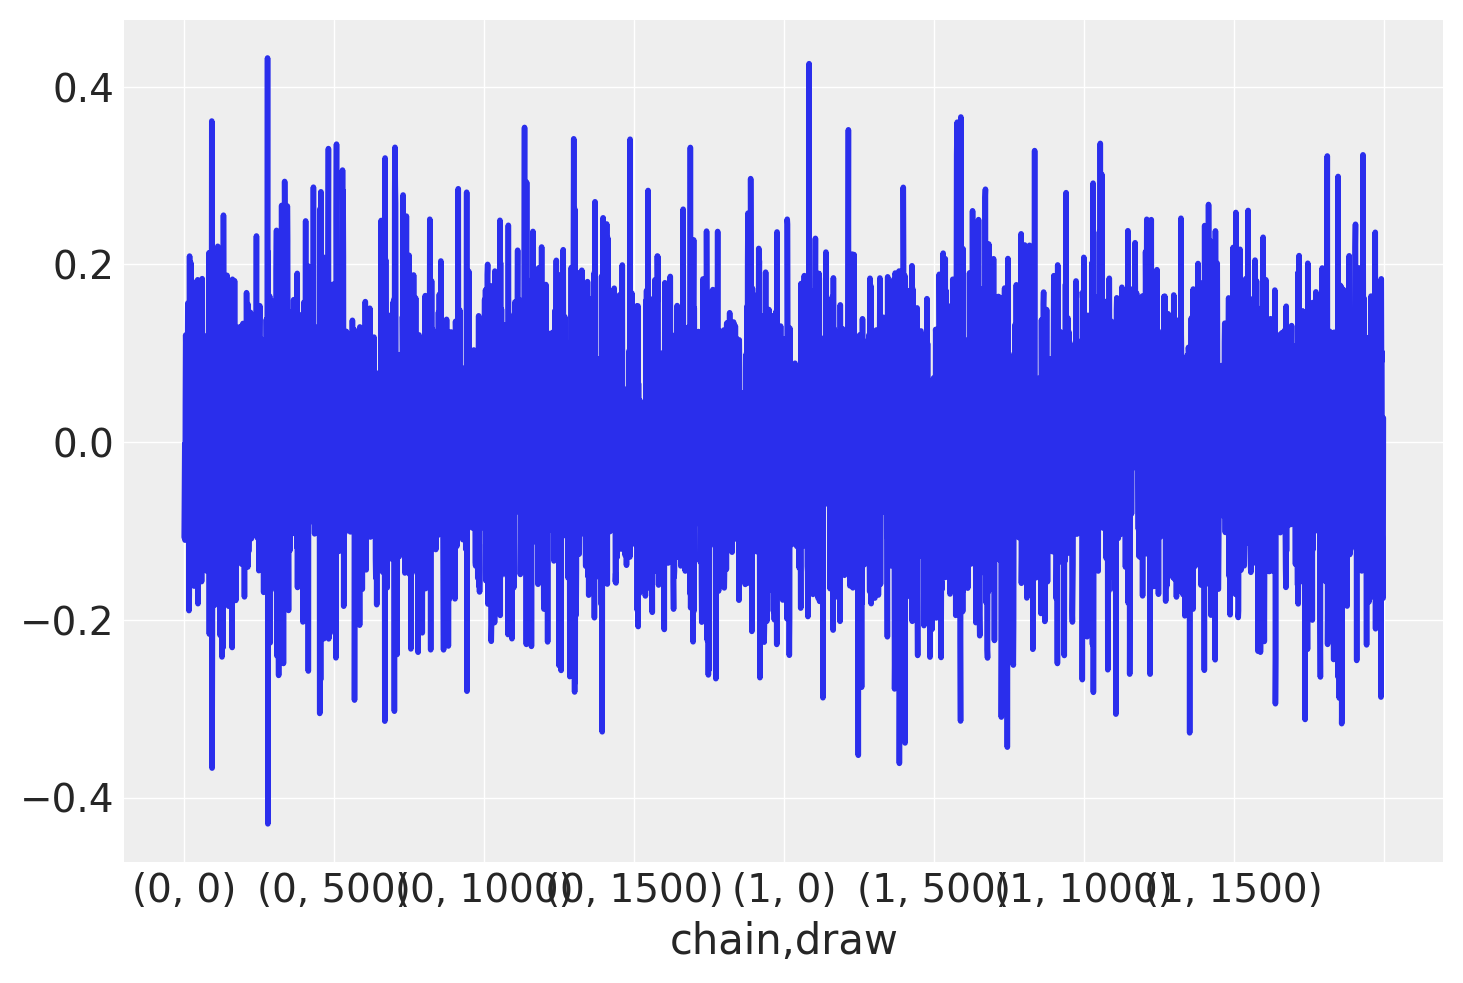

In [38]:
df_idata_1['a'].plot()

In [39]:
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)
posterior_mu.shape

(4000, 50)

In [40]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)

In [41]:
def plot_regression(x, y_mean, y_hpdi):
  # Sort values for plotting by x axis
  idx = jnp.argsort(x)
  marriage = x[idx]
  mean = y_mean[idx]
  hpdi = y_hpdi[:, idx]
  divorce = dset.DivorceScaled.values[idx]

  # Plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
  ax.plot(marriage, mean)
  ax.plot(marriage, divorce, "o")
  ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
  return ax

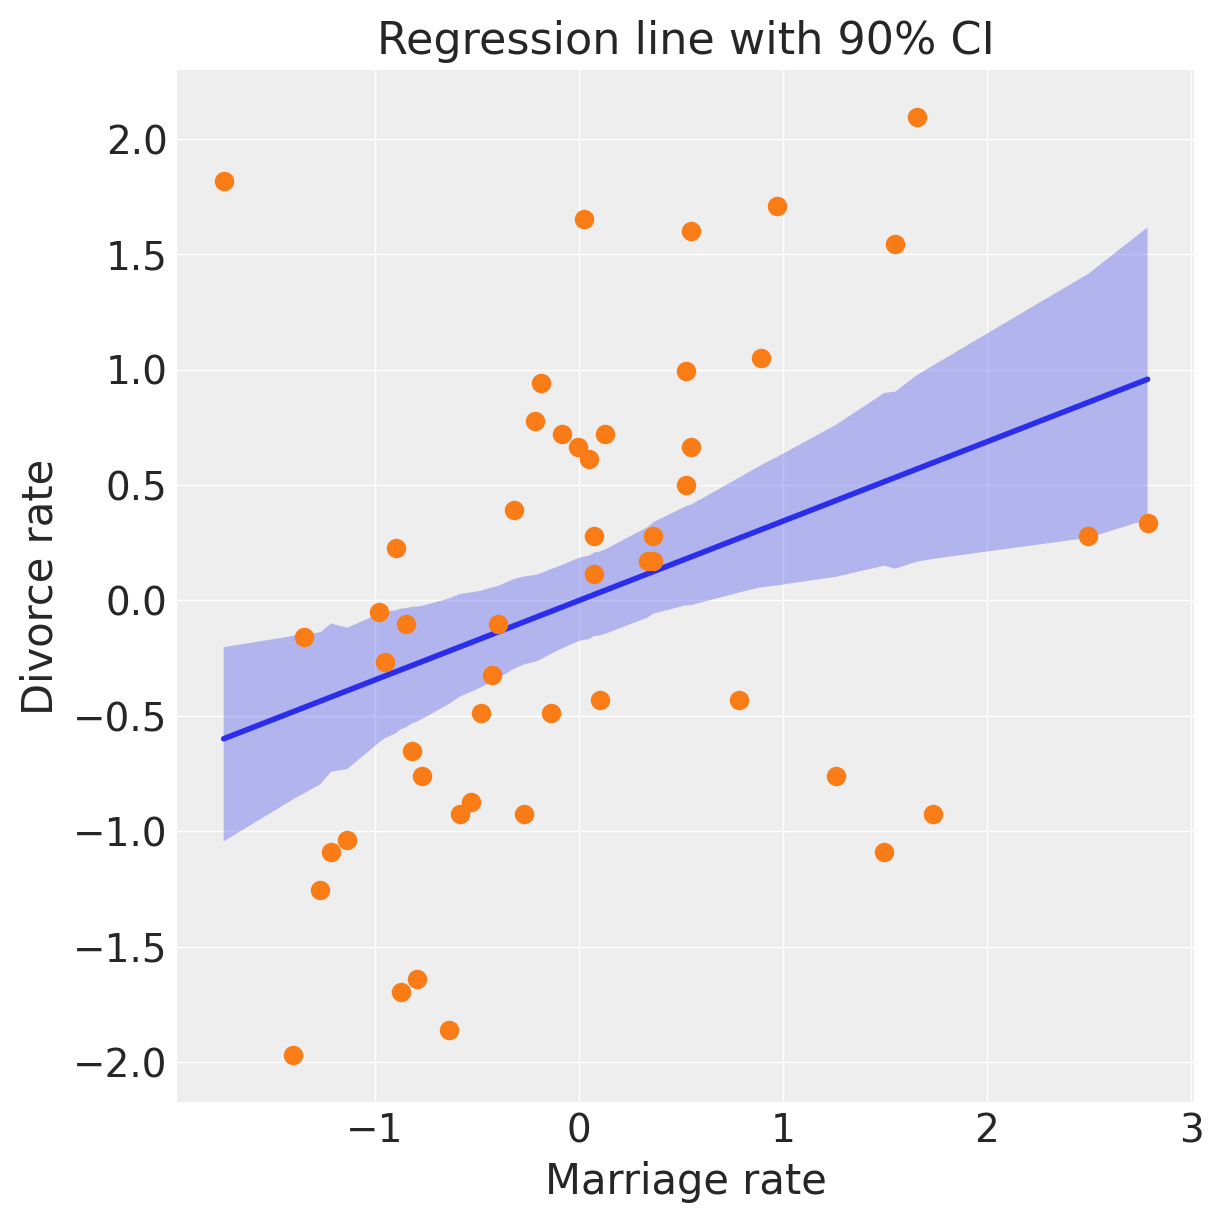

In [42]:
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI",
);

In [44]:
dset.MarriageScaled.values

array([ 0.02264406,  1.54980162,  0.04897436,  1.65512283, -0.26698927,
        0.89154405, -0.79359532,  0.78622284, -0.63561351, -0.81992563,
        0.52291981,  1.26016829,  1.49714101, -0.5829529 , -0.08267715,
        0.364938  ,  0.52291981,  0.54925012,  0.12796527, -1.74148622,
       -0.47763169, -1.13588926, -0.95157714, -1.26754077, -0.21432866,
       -0.39864078, -0.42497109, -0.13533776, -0.89891654, -1.39919229,
        0.07530467, -0.87258623,  0.07530467,  1.73411374, -0.84625593,
        0.97053496, -0.31964988, -1.21488017, -1.34653168, -0.5302923 ,
       -0.00368624, -0.18799836,  0.364938  ,  2.49769252, -0.97790744,
        0.10163497,  0.33860769,  0.54925012, -0.76726502,  2.78732585])